In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2022-07-05 18:10:03.714134+02:00


# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))

# 1. Read single-cell data

In [5]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('/g/arendt/npapadop/repos/spongfold/data/spongilla_basic.h5ad')

In [6]:
numbers = ['2', '3', '6', '7', '12', '13', '14', '15', '16', '17', '19', '20', '23', '26', '29', '32', '34', '38', '42']
keep = ~adata.obs['cell_type'].isin(numbers)
adata = adata[keep].copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 5625 × 39562
    obs: 'cell_type', 'cell_type_abbreviation', 'cell_type_family', 'clusterID', 'nCount_RNA', 'nFeature_RNA', 'orig.ident'
    layers: 'counts', 'scale.data'

# 2. Set up gene annotation

In [8]:
# create a naked gene_id column to merge on
adata.var['gene_id'] = adata.var.index.str.split().str[0].str.replace('-', '_')
adata.var['legacy name'] = adata.var.index.values
adata.var.set_index('gene_id', inplace=True)
# read foldseek annotation and keep relevant columns
annot = pd.read_csv("/g/arendt/npapadop/repos/spongfold/data/spongilla_lut.tsv", sep='\t')
annot_nodoubl = annot.sort_values('bit score', ascending=False).drop_duplicates('gene_id')
keep = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Description_seq', 'Description_struct', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']
annot_nodoubl = annot_nodoubl[keep]
adata.var = adata.var.join(annot_nodoubl.set_index('gene_id'), how='left')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
seq_isnan = adata.var["Preferred_name_seq"].isnull()
seq_missing = adata.var["Preferred_name_seq"] == "-"
seq_no_desc = adata.var["Description_seq"].isnull()
seq_desc_mis = adata.var["Description_seq"] == "-"

struct_isnan = adata.var["Preferred_name_struct"].isnull()
struct_missing = adata.var["Preferred_name_struct"] == "-"
struct_no_desc = adata.var["Description_struct"].isnull()
struct_desc_mis = adata.var["Description_struct"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)

In [10]:
adata.var['gene_id'] = adata.var.index.values

In [11]:
# build best sequence annotation
has_seq_desc_but_no_seq_name = seq_has_desc & ~seq_has_name
seq_unannotated = ~(seq_has_name | has_seq_desc_but_no_seq_name)
seq_named = adata.var["gene_id"][seq_has_name] + " | " + "[" + adata.var["Preferred_name_seq"][seq_has_name] + "]"
seq_described = adata.var["gene_id"][has_seq_desc_but_no_seq_name] + " | [" + adata.var["Description_seq"][has_seq_desc_but_no_seq_name] +"]"
seq_unnamed = adata.var["gene_id"][seq_unannotated]
seq_names = pd.DataFrame(seq_named.append(seq_described).append(seq_unnamed))
seq_names.columns = ['best seq. name']

In [12]:
# build best structure annotation
has_struct_desc_but_no_struct_name = struct_has_desc & ~struct_has_name
struct_unannotated = ~(struct_has_name | has_struct_desc_but_no_struct_name)
struct_named = adata.var["gene_id"][struct_has_name] + " | (" + adata.var["Preferred_name_struct"][struct_has_name] + ')'
struct_described = adata.var["gene_id"][has_struct_desc_but_no_struct_name] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_struct_name] + ")"
struct_unnamed = adata.var["gene_id"][struct_unannotated]
struct_names = pd.DataFrame(struct_named.append(struct_described).append(struct_unnamed))
struct_names.columns = ['best struct. name']

In [13]:
# best overall annotation
# first sequence name, then sequence description
# then structure name, then structure description
has_struct_name_but_no_seq_any = seq_unannotated & struct_has_name
has_struct_desc_but_no_else = seq_unannotated & ~struct_has_name & struct_has_desc
unannotated = ~(seq_has_name | seq_has_desc | struct_has_name | struct_has_desc)

struct_named_no_seq = adata.var["gene_id"][has_struct_name_but_no_seq_any] + " | (" + adata.var["Preferred_name_struct"][has_struct_name_but_no_seq_any] + ")"
struct_desc_nothing_else = adata.var["gene_id"][has_struct_desc_but_no_else] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_else] + ")"
unnamed = adata.var["gene_id"][unannotated]

best_names = pd.DataFrame(seq_named.append(seq_described).append(struct_named_no_seq).append(struct_desc_nothing_else).append(unnamed))
best_names.columns = ['best name']

In [14]:
struct_names.shape, seq_names.shape, best_names.shape

((39562, 1), (39562, 1), (39562, 1))

In [15]:
adata.var = adata.var.join(seq_names)
adata.var = adata.var.join(struct_names)
adata.var = adata.var.join(best_names)

In [16]:
has_name = adata.var['legacy name'].str.contains(' ')

replace = {}
for i,j in zip(adata.var['best name'][has_name].values, adata.var['legacy name'][has_name].values):
    replace[i] = j

adata.var['fusion'] = adata.var['best name'].replace(replace)

In [17]:
celltypes_by_family = [
    'Incurrent Pinacocytes1', 'Incurrent Pinacocytes2',
    'Apendopinacocytes1', 'Apendopinacocytes2', 'Lophocytes', 'Basopinacocytes', 'Sclerophorocytes', 'Metabolocytes1',
    'Metabolocytes2', 'Archaeocytes', 'Apopylar Cells', 'Sclerocytes', 'Mesocytes 1',
    'Mesocytes 2', 'Mesocytes 3', 'Choanoblasts1', 'Choanoblasts2', 'Choanocytes',
    'Myopeptidocytes1', 'Myopeptidocytes2', 'Amoebocytes', 'Granulocytes', 'Neuroid'
]

In [18]:
celltypes_by_family_abb = [
    'incPin1', 'incPin2',
    'apnPin1', 'apnPin2', 'Lph', 'basPin', 'Scp', 'Met1',
    'Met2', 'Chb1', 'Chb2', 'Cho', 'Apo', 
    'Myp1', 'Myp2', 'Amb', 'Grl', 'Nrd', 'Mes1',
    'Mes2', 'Mes3', 'Arc', 'Scl',
]

### FGF, TGF/BMP and Ephrin signaling in the pinacocyte family

In [29]:
FGFR_jake = ['c103847_g2', 'c91448_g2', 'c103216_g1', 'c102874_g2', 'c104319_g1'] 
FGFR_coffe  = ['c102743_g2', 'c101244_g1', 'c101095_g1', 'c103779_g3', 'c93283_g1', 'c103635_g1']

TGF_jake = ['c102237_g1', 'c100624_g1', 'c42918_g1', 'c99958_g1', 'c101050_g1', 'c103829_g1', 'c102832_g1', 'c111603_g1']
TGF_coffe = ['c99581_g1', 'c94044_g2', 'c98653_g1', 'c81379_g1', 'c91200_g1', 'c95584_g1', 'c99909_g1', 'c50424_g1', 'c88496_g1']

FGF_BMP_txf = ['c101327_g2']

Ephrin_jake = ['c100872_g1', 'c103804_g1', 'c104279_g1', 'c104628_g1', 'c39133_g1']
Ephrin_coffe = ['c102445_g1']

Downstream_effectors_jake = ['c102591_g1', 'c102631_g3', 'c100448_g1', 'c103372_g3', 'c101130_g1', 'c91721_g1', 'c103684_g1', 'c104144_g1', 'c102135_g4', 'c87465_g1', 'c101822_g1']
Downsteam_effectors_coffe = ['c93150_g1', 'c93757_g1', 'c96657_g1']


In [30]:
adata.var['manual'] = adata.var.index

In [31]:
replace = {
    'c103847_g2': 'c103847_g2 | FGFR1/2/3/4',
    'c91448_g2': 'c91448_g2 | FGFR1',
    'c103216_g1': 'c103216_g1 | GRB2',
    'c102874_g2': 'c102874_g2 | FRS3',
    'c104319_g1': 'c104319_g1 | SOS',
    'c102743_g2': 'c102743_g2 | FGF4',
    'c101244_g1': 'c101244_g1 | FGFR4',
    'c101095_g1': 'c101095_g1 | GAB1',
    'c103779_g3': 'c103779_g3 | GAB2',
    'c93283_g1': 'c93283_g1 | PTPN11',
    'c103635_g1': 'c103635_g1 | PTPN11',
    'c102237_g1': 'c102237_g1 | TGFBR1',
    'c101050_g1': 'c101050_g1 | SMAD1/5/9',
    'c103829_g1': 'c103829_g1 | SMURF1/2',
    'c99958_g1': 'c99958_g1 | BMP6',
    'c111603_g1': 'c111603_g1 | CRIM1',
    'c42918_g1': 'c42918_g1 | BMPR1A',
    'c99581_g1': 'c99581_g1 | INHBE',
    'c94044_g2': 'c94044_g2 | GDF15',
    'c98653_g1': 'c98653_g1 | DAN containing',
    'c81379_g1': 'c81379_g1 | KCP',
    'c91200_g1': 'c91200_g1 | CHRDL1',
    'c95584_g1': 'c95584_g1 | FNDC4',
    'c99909_g1': 'c99909_g1 | TGFB2',
    'c50424_g1': 'c50424_g1 | BMP6',
    'c88496_g1': 'c88496_g1 | IGF2R',
    'c102354_g1': 'c102354_g1 | ISL2',
    'c101130_g1': 'c101130_g1 | MAPK8/9/10 - JNK',
    'c102591_g1': 'c102591_g1 | PIK3R1/2/3',
    'c100448_g1': 'c100448_g1 | PDPK1',
    'c102631_g3': 'c102631_g3 | PIK3CB',
    'c101822_g1': 'c101822_g1 | AKT',
    'c103372_g3': 'c103372_g3 | MAPK1/3',
    'c91721_g1': 'c91721_g1 | RhoA',
    'c104144_g1': 'c104144_g1 | ROCK1/2',
    'c102135_g4': 'c102135_g4 | Src family kinase',
    'c87465_g1': 'c87465_g1 | RAC1/2/3',
    'c101327_g2': 'c101327_g2 | FOXO',
    'c103684_g1': 'c103684_g1 | RhoV/U',
    'c93150_g1': 'c93150_g1 | SKAP1',
    'c93757_g1': 'c93757_g1 | ARHGEF17',
    'c96657_g1': 'c96657_g1 | MPRIP',
    'c100872_g1': 'c100872_g1 | EPHA',
    'c103804_g1': 'c103804_g1 | EPHB',
    'c104279_g1': 'c104279_g1 | EPHA',
    'c104628_g1': 'c104628_g1 | EPHA',
    'c102445_g1': 'c102445_g1 | Ephrin',
    'c39133_g1': 'c39133_g1 | TIAM1/2',
    'c100624_g1': 'c100624_g1 | ACVR/L',
    'c102832_g1': 'c102832_g1 | TGFBI'
}

In [32]:
adata.var['manual'] = adata.var['manual'].replace(replace)

In [33]:
pinacocytes_toplot = FGFR_jake + FGFR_coffe + TGF_jake + TGF_coffe + Ephrin_jake + Ephrin_coffe + Downstream_effectors_jake + Downsteam_effectors_coffe

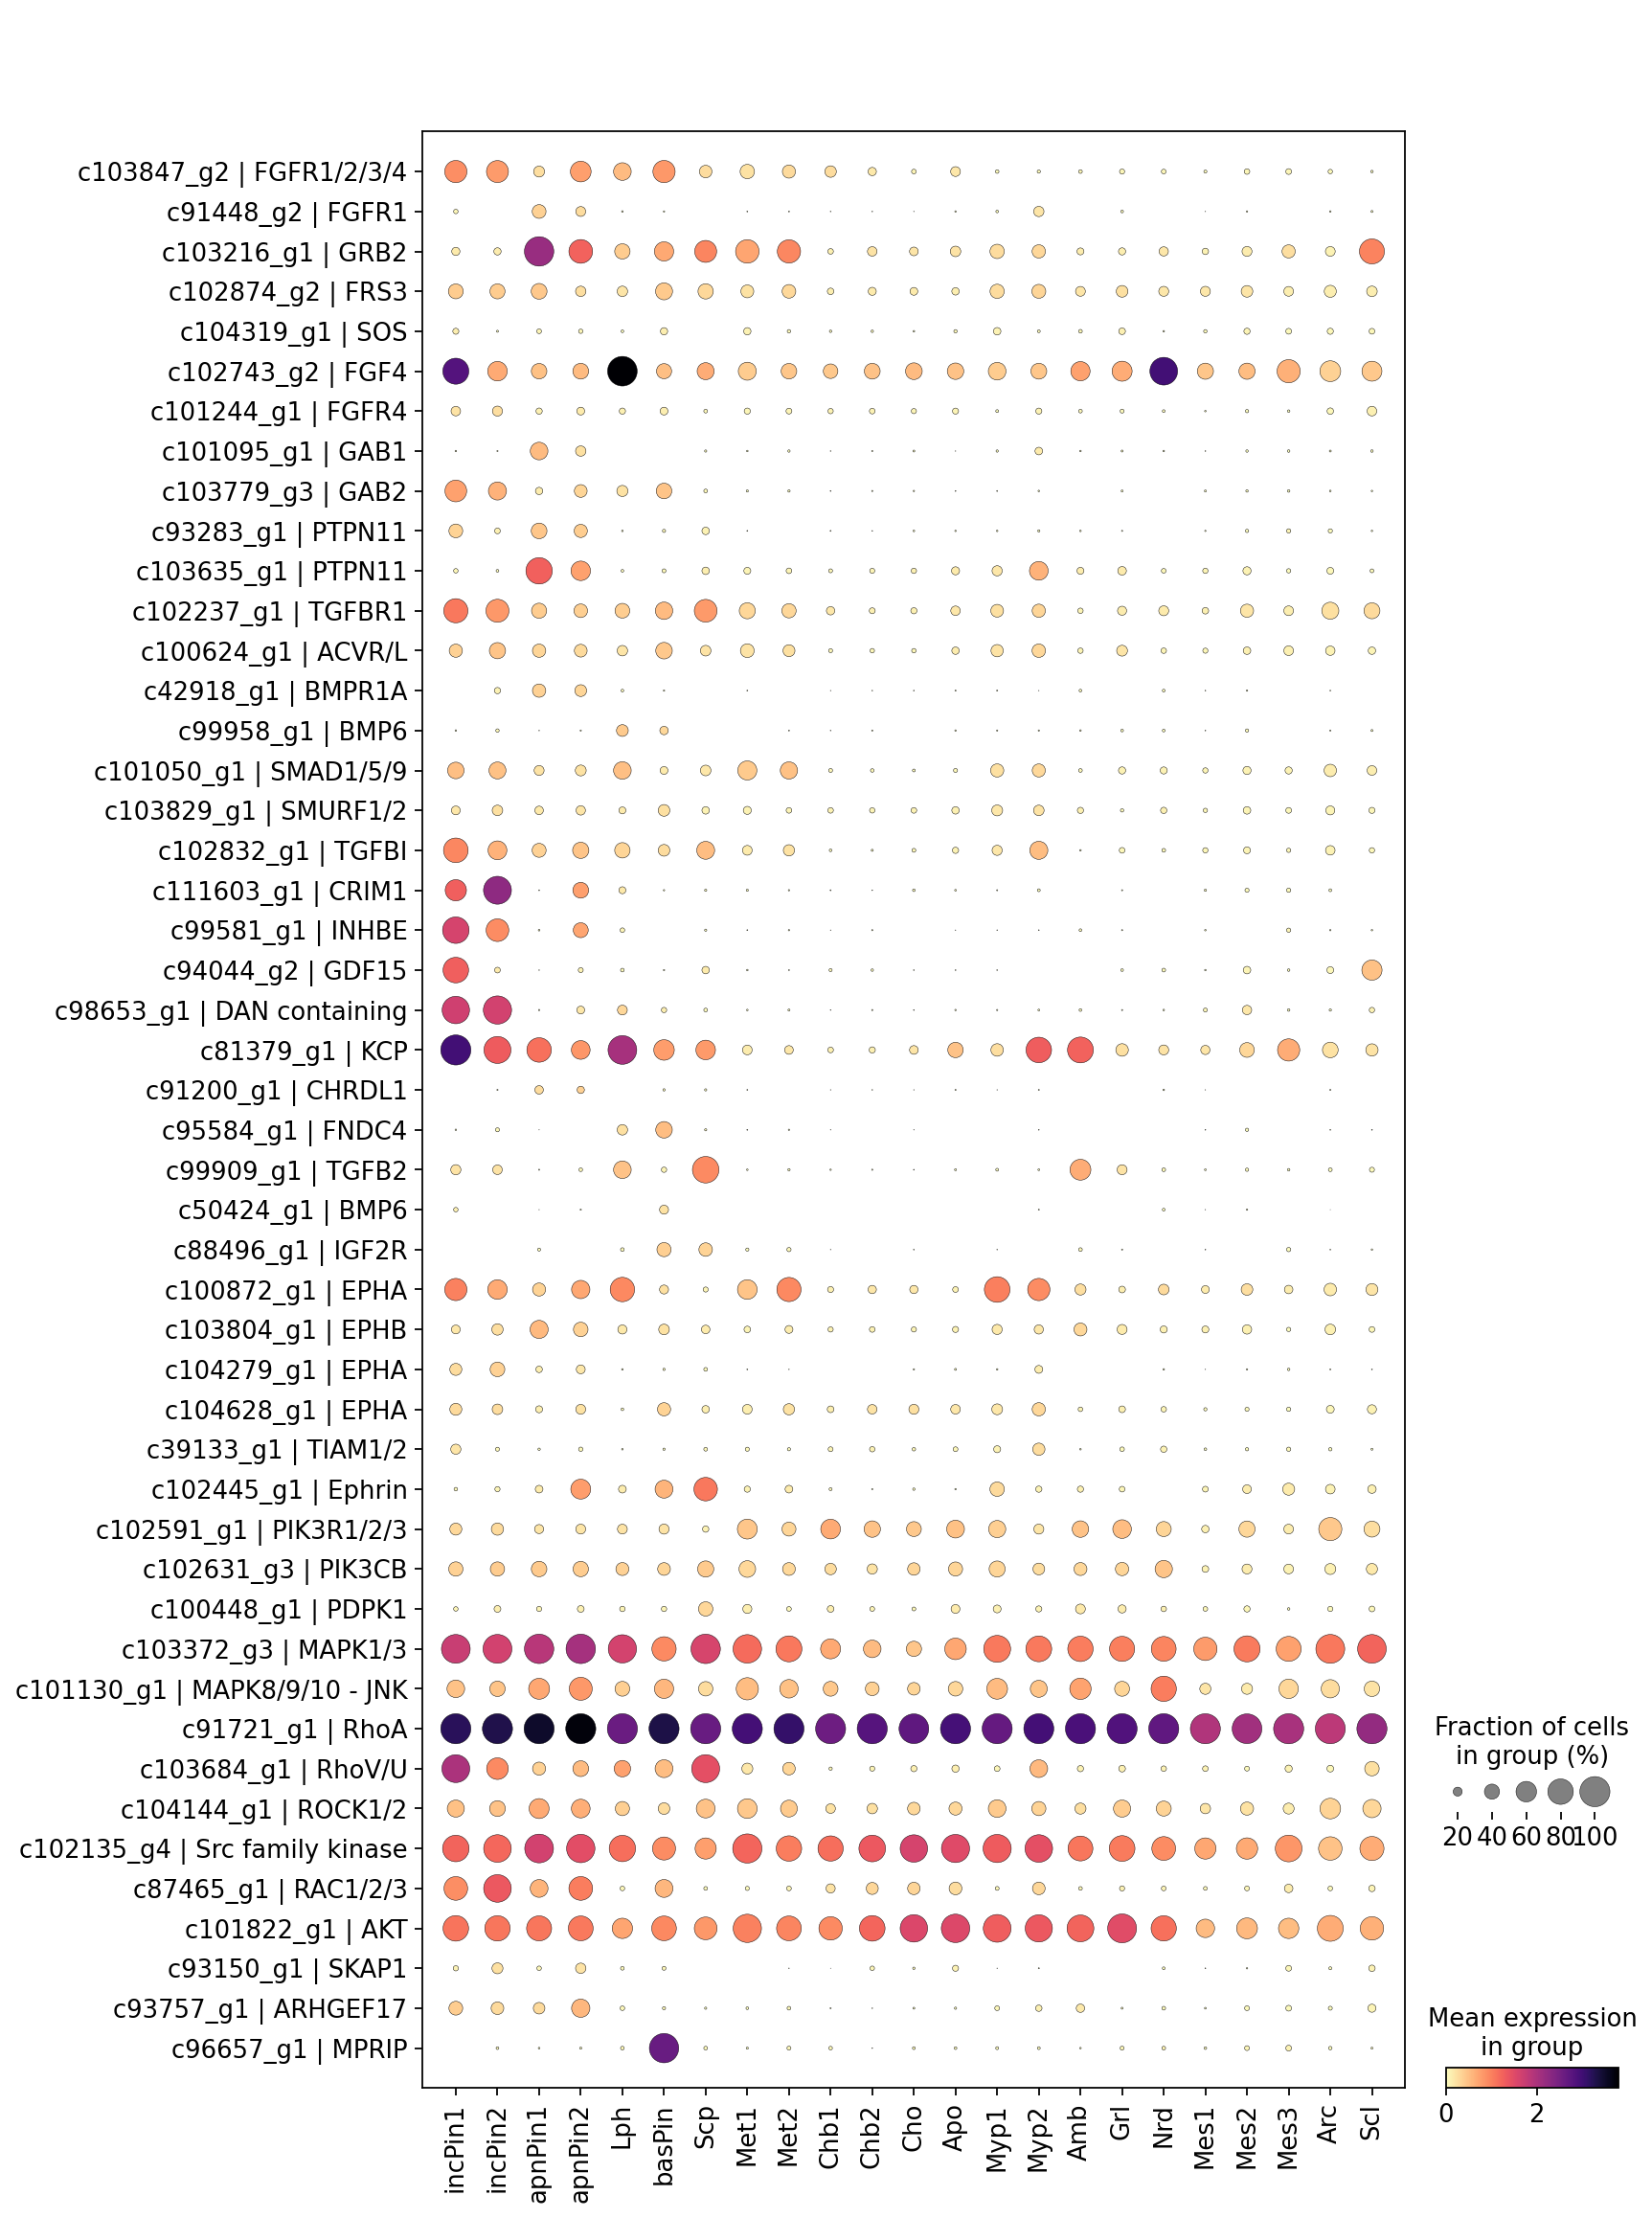

In [34]:
sc.pl.dotplot(adata, var_names=adata.var.loc[pinacocytes_toplot]['manual'],
              groupby='cell_type_abbreviation', swap_axes=True,
              cmap='magma_r', gene_symbols='manual', categories_order=celltypes_by_family_abb, save="pin_dotplot.svg")

In [44]:
HGT_candidates = ['c102757_g1', 'c95037_g1', 'c103983_g1',
              'c95922_g2', 'c97085_g1', 'c97022_g1',
              'c101393_g1', 'c100625_g2', 'c112781_g1',
              'c102838_g2']

annotation = ['emapper: Inherit from COG: Scp-like extracellular | CoFFE: yoaJ',
              'emapper: Cell Wall|CoFFE: sleB', 'emapper: Aminohydrolase',
              'CoFFE: T5orf172', 'emapper: GMHA (phosphoheptose isomerase)',
              'emapper: Metallopeptidase M20 family', 'emapper: BG3',
              'CoFFE: Endochitinase', 'CoFFE: Belongs to the glycosyl hydrolase 5 (cellulase A) family',
              'CoFFE: Chitinase class I']

In [45]:
replace = {
    'c102757_g1': 'emapper: Inherit from COG: Scp-like extracellular | CoFFE: yoaJ',
    'c95037_g1': 'emapper: Cell Wall | CoFFE: sleB',
    'c103983_g1': 'emapper: Aminohydrolase',
    'c95922_g2': 'CoFFE: T5orf172',
    'c97085_g1': 'emapper: GMHA (phosphoheptose isomerase)',
    'c97022_g1': 'emapper: Metallopeptidase M20 family',
    'c101393_g1': 'emapper: BG3',
    'c100625_g2': 'CoFFE: Endochitinase',
    'c112781_g1': 'CoFFE: Belongs to the glycosyl hydrolase 5 (cellulase A) family',
    'c102838_g2': 'CoFFE: Chitinase class I'
}

In [46]:
adata.var['manual'] = adata.var['manual'].replace(replace)

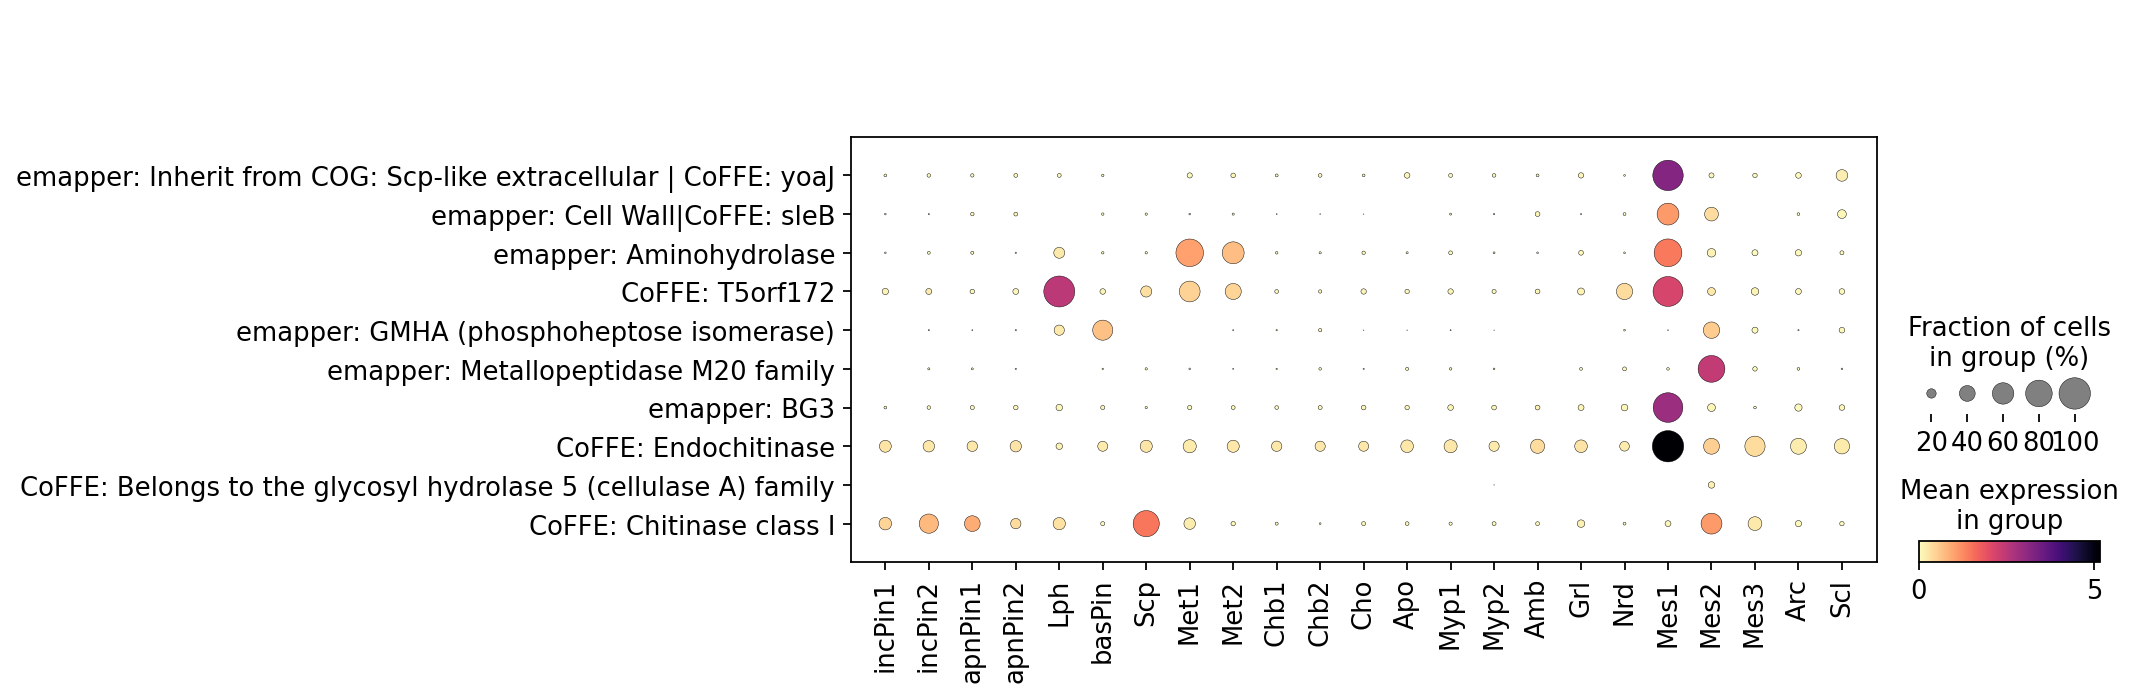

In [47]:
sc.pl.dotplot(adata, var_names=adata.var.loc[HGT_candidates]['manual'],
              groupby='cell_type_abbreviation', swap_axes=True,
              cmap='magma_r', gene_symbols='manual', categories_order=celltypes_by_family_abb)